# Note to Participants
The code is adapted from an implementation from https://github.com/huggingface/transformers/issues/28778, utilizing a custom loss function and is meant to broadly point participants in the general direction of what it would take to fine-tune the OWL-ViT model. As such, teams are strongly encouraged to explore, change, and improve the training script that follows.

# Library

In [4]:
import torch
import os

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Logging

In [5]:
import logging

# Configure logging (example for `logging` module)
logging.basicConfig(
    level=logging.WARNING,  # Adjust as needed (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)


# References
- https://github.com/huggingface/transformers/issues/28778
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

Also helpful, but through google's research scenic repo
- https://github.com/google-research/scenic/issues/542

And also, nvidia implement
- https://github.com/NVIDIA-AI-IOT/nanoowl

In [6]:
import os

# path of images
# path of jsonfile to load data
home_dir = os.path.expanduser('~')
print(home_dir)
proj_dir = os.path.join(home_dir, 'PycharmProjects', 'til-ai-degens')
print(proj_dir)
image_dir = os.path.join(proj_dir, 'novice', 'images')
print(image_dir)
annot_dir = os.path.join(proj_dir, 'novice')
print(annot_dir)

C:\Users\yuhao
C:\Users\yuhao\PycharmProjects\til-ai-degens
C:\Users\yuhao\PycharmProjects\til-ai-degens\novice\images
C:\Users\yuhao\PycharmProjects\til-ai-degens\novice


# Loading Dataset

In [7]:
os.getcwd()

'C:\\Users\\yuhao\\PycharmProjects\\til-ai-degens\\vlm\\src'

## Loading Image Dataset

In [8]:
from datasets import load_dataset

image_dataset = load_dataset("imagefolder", data_dir=image_dir)
image_dataset

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 1000
    })
})

In [9]:
image_dataset = image_dataset["train"]

## Loading Annotations

In [10]:
# Load data from vlm.jsonl
import json


def load_jsonl(a_dir):
    dataset = []
    with open(a_dir + '/vlm.jsonl', 'r') as f:
        for line in f:
            if line.strip().startswith('//'):
                continue 
            data = json.loads(line)
            dataset.append(data)
    return dataset


In [11]:
annot_dataset = load_jsonl(annot_dir)
annot_dataset


[{'image': 'image_0.jpg',
  'annotations': [{'caption': 'blue and white missile',
    'bbox': [1224, 284, 44, 36]},
   {'caption': 'green light aircraft', 'bbox': [688, 400, 56, 36]},
   {'caption': 'blue and white commercial aircraft',
    'bbox': [800, 320, 128, 36]}]},
 {'image': 'image_1.jpg',
  'annotations': [{'caption': 'blue commercial aircraft',
    'bbox': [1156, 496, 104, 60]},
   {'caption': 'white and yellow commercial aircraft',
    'bbox': [1296, 488, 136, 44]}]},
 {'image': 'image_2.jpg',
  'annotations': [{'caption': 'white and blue fighter jet',
    'bbox': [488, 196, 52, 44]},
   {'caption': 'blue and yellow fighter jet', 'bbox': [836, 464, 36, 36]},
   {'caption': 'grey and white fighter plane', 'bbox': [1060, 208, 64, 32]}]},
 {'image': 'image_3.jpg',
  'annotations': [{'caption': 'grey camouflage fighter jet',
    'bbox': [212, 444, 72, 64]},
   {'caption': 'grey and black helicopter', 'bbox': [912, 144, 40, 28]},
   {'caption': 'grey commercial aircraft', 'bbox':

In [12]:
len(annot_dataset)

1000

## Generating Labels

In [13]:
# create label2id
category_labels = []
for data in annot_dataset:
    for label in data['annotations']:
        category_labels.append(label['caption'])
category_labels
    

['blue and white missile',
 'green light aircraft',
 'blue and white commercial aircraft',
 'blue commercial aircraft',
 'white and yellow commercial aircraft',
 'white and blue fighter jet',
 'blue and yellow fighter jet',
 'grey and white fighter plane',
 'grey camouflage fighter jet',
 'grey and black helicopter',
 'grey commercial aircraft',
 'red helicopter',
 'green and black camouflage helicopter',
 'grey and red fighter jet',
 'black fighter plane',
 'silver fighter plane',
 'white and orange light aircraft',
 'red and white fighter jet',
 'grey and red missile',
 'white and blue fighter plane',
 'blue commercial aircraft',
 'yellow and green helicopter',
 'red and white fighter jet',
 'white and grey helicopter',
 'white and red missile',
 'yellow, red, and blue fighter plane',
 'white and red commercial aircraft',
 'black cargo aircraft',
 'yellow helicopter',
 'white and orange commercial aircraft',
 'white and black light aircraft',
 'white, black, and grey missile',
 'whit

In [14]:
len(category_labels)

3036

In [15]:
labels2id = {}
counter = 0
for v in category_labels:
    if v not in labels2id.keys():
        labels2id[v] = counter
        counter+=1
        continue
labels2id

{'blue and white missile': 0,
 'green light aircraft': 1,
 'blue and white commercial aircraft': 2,
 'blue commercial aircraft': 3,
 'white and yellow commercial aircraft': 4,
 'white and blue fighter jet': 5,
 'blue and yellow fighter jet': 6,
 'grey and white fighter plane': 7,
 'grey camouflage fighter jet': 8,
 'grey and black helicopter': 9,
 'grey commercial aircraft': 10,
 'red helicopter': 11,
 'green and black camouflage helicopter': 12,
 'grey and red fighter jet': 13,
 'black fighter plane': 14,
 'silver fighter plane': 15,
 'white and orange light aircraft': 16,
 'red and white fighter jet': 17,
 'grey and red missile': 18,
 'white and blue fighter plane': 19,
 'yellow and green helicopter': 20,
 'white and grey helicopter': 21,
 'white and red missile': 22,
 'yellow, red, and blue fighter plane': 23,
 'white and red commercial aircraft': 24,
 'black cargo aircraft': 25,
 'yellow helicopter': 26,
 'white and orange commercial aircraft': 27,
 'white and black light aircraft'

In [16]:
def create_label2id(dataset):
    labels = []
    for data in dataset:
        for label in data['annotations']:
            labels.append(label['caption'])
    labels2id = {}
    counter = 0
    for v in labels:
        if v not in labels2id.keys():
            labels2id[v] = counter
            counter+=1
            continue
    return labels2id

In [17]:
label2id = create_label2id(annot_dataset)

In [18]:
def label2id_to_id2label(label2id):
    id2label = {}
    for k, v in label2id.items():
        id2label[v] = k
    return id2label

id2label = label2id_to_id2label(label2id)
id2label

{0: 'blue and white missile',
 1: 'green light aircraft',
 2: 'blue and white commercial aircraft',
 3: 'blue commercial aircraft',
 4: 'white and yellow commercial aircraft',
 5: 'white and blue fighter jet',
 6: 'blue and yellow fighter jet',
 7: 'grey and white fighter plane',
 8: 'grey camouflage fighter jet',
 9: 'grey and black helicopter',
 10: 'grey commercial aircraft',
 11: 'red helicopter',
 12: 'green and black camouflage helicopter',
 13: 'grey and red fighter jet',
 14: 'black fighter plane',
 15: 'silver fighter plane',
 16: 'white and orange light aircraft',
 17: 'red and white fighter jet',
 18: 'grey and red missile',
 19: 'white and blue fighter plane',
 20: 'yellow and green helicopter',
 21: 'white and grey helicopter',
 22: 'white and red missile',
 23: 'yellow, red, and blue fighter plane',
 24: 'white and red commercial aircraft',
 25: 'black cargo aircraft',
 26: 'yellow helicopter',
 27: 'white and orange commercial aircraft',
 28: 'white and black light aircr

## Processing Annotations

In [19]:
# Processing annotations to be in a list
def process_annotations(annot_dataset, image_dataset):
    label_id_counter = 0
    image_id = []
    width = []
    height = []
    objects = []
    
    for i in range(len(annot_dataset)):
        print(f"Processing image {i}")
        _image = image_dataset[i]["image"]
        image_size = _image.size
        width.append(image_size[0])
        height.append(image_size[1])
        image_id.append(i) 
        
        # for each image populate the labels
        label_id = []
        area = []
        bbox = []
        category = []
        annotations = annot_dataset[i]["annotations"]
        for ann in annotations:
            _bbox = ann["bbox"]
            _caption = ann["caption"]
            _category = label2id[_caption]
            _area = image_size[0] * image_size[1]
            
            label_id.append(label_id_counter)
            label_id_counter+=1
            area.append(_area)
            bbox.append(_bbox)
            category.append(_category)
            
        objects.append({"id": label_id, "area": area, "bbox": bbox, "category": category})
            
            
    result = {
        'image_id': image_id, 'width': width, 'height': height, 'objects': objects
    }
            
                 
    return result

In [20]:
processed_annot_dataset = process_annotations(annot_dataset, image_dataset)

Processing image 0
Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing

In [21]:
processed_annot_dataset.keys()

dict_keys(['image_id', 'width', 'height', 'objects'])

## Combining Image dataset with Annotations

In [22]:
combined_dataset = image_dataset.add_column('image_id', processed_annot_dataset["image_id"])
combined_dataset = combined_dataset.add_column('width', processed_annot_dataset['width'])
combined_dataset = combined_dataset.add_column('height', processed_annot_dataset['height'])
combined_dataset = combined_dataset.add_column('objects', processed_annot_dataset['objects'])
combined_dataset.features


{'image': Image(mode=None, decode=True, id=None),
 'image_id': Value(dtype='int64', id=None),
 'width': Value(dtype='int64', id=None),
 'height': Value(dtype='int64', id=None),
 'objects': {'area': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
  'category': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}}

# Model & Processor

In [23]:
from transformers import AutoImageProcessor
from transformers import AutoProcessor

# using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)

from transformers import AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

print("loaded!")

# other better checkpoints, but would run out of memory with current T4 instance for fine-tuning, could be use for inference
# google/owlv2-base-patch16
# google/owlv2-large-patch14-finetuned
# google/owlv2-base-patch16-ensemble
# while with significant better performance, would run into OOM (Out of memory)

loaded!


In [24]:
from PIL import Image
inputs = processor(text=["blue and white missile"], images=[Image.open(f"{image_dir}/image_0.jpg")])
print(inputs["input_ids"].shape)
print(inputs["attention_mask"].shape)
inputs["pixel_values"].shape

(1, 16)
(1, 16)


(1, 3, 768, 768)

In [25]:
import albumentations
import numpy as np

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    transformed_data = []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        transformed_data.append(processor(text=category_labels, images=image, return_tensors="pt"))


    return {"transformed_data":transformed_data}

# transforming a batch
def transform_aug_ann_labels(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def collate_fn(batch):
    # defining the processed input ids, attention masks and pixel_values as tensors
    input_ids = torch.Tensor([item["input_ids"] for item in batch]).int()
    input_ids = input_ids.to(device)
    attention_mask = torch.Tensor([item["attention_mask"] for item in batch]).int()
    attention_mask = attention_mask.to(device)
    pixel_values = torch.Tensor([item["pixel_values"] for item in batch])
    pixel_values = pixel_values.to(device)
    
    # converting the labels to tensors
    labels = []
    for item in batch:
        for (key, value) in item["labels"].items():
            item["labels"][key] = torch.Tensor(value).to(device)
        labels.append(item["labels"])

    batch = {}
    batch["input_ids"] = input_ids
    batch["attention_mask"] = attention_mask
    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

In [26]:
#applying to the datasets
transform_1 = combined_dataset.with_transform(transform_aug_ann)
transform_2 = combined_dataset.with_transform(transform_aug_ann_labels)

In [27]:
import pandas as pd
from datasets import Dataset

def dataset_prep_generator(transform_1, transform_2):
    for i in range(len(transform_1)):
        dict_ = {}
        dict_["input_ids"] = transform_1[i]["transformed_data"]["input_ids"]
        dict_["attention_mask"] = transform_1[i]["transformed_data"]["attention_mask"]
        dict_["pixel_values"] = transform_1[i]["transformed_data"]["pixel_values"][0]
        dict_["labels"] = transform_2[i]["labels"]
        yield dict_

train_dataset = Dataset.from_generator(
    lambda: dataset_prep_generator(transform_1, transform_2),
    keep_in_memory=False,
    cache_dir="./dataset_cache",
)
train_dataset.features

{'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'labels': {'area': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
  'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'orig_size': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'size': Sequence(feature=Value(dtype='int

## Encoding the data into Dataset

## Detection

In [28]:
# Using Detr-Loss calculation https://github.com/facebookresearch/detr/blob/main/models/matcher.py
# https://www.kaggle.com/code/bibhasmondal96/detr-from-scratch
class BoxUtils(object):
    @staticmethod
    def box_cxcywh_to_xyxy(x):
        x_c, y_c, w, h = x.unbind(-1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
             (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def box_xyxy_to_cxcywh(x):
        x0, y0, x1, y1 = x.unbind(-1)
        b = [(x0 + x1) / 2, (y0 + y1) / 2,
             (x1 - x0), (y1 - y0)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def rescale_bboxes(out_bbox, size):
        img_h, img_w = size
        b = BoxUtils.box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    @staticmethod
    def box_area(boxes):
        """
        Computes the area of a set of bounding boxes, which are specified by its
        (x1, y1, x2, y2) coordinates.
        Arguments:
            boxes (Tensor[N, 4]): boxes for which the area will be computed. They
                are expected to be in (x1, y1, x2, y2) format
        Returns:
            area (Tensor[N]): area for each box
        """
        return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    @staticmethod
    # modified from torchvision to also return the union
    def box_iou(boxes1, boxes2):
        area1 = BoxUtils.box_area(boxes1)
        area2 = BoxUtils.box_area(boxes2)

        lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
        rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        union = area1[:, None] + area2 - inter

        iou = inter / union
        return iou, union

    @staticmethod
    def generalized_box_iou(boxes1, boxes2):
        """
        Generalized IoU from https://giou.stanford.edu/
        The boxes should be in [x0, y0, x1, y1] format
        Returns a [N, M] pairwise matrix, where N = len(boxes1)
        and M = len(boxes2)
        """
        # degenerate boxes gives inf / nan results
        # so do an early check
        assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
        assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
        iou, union = BoxUtils.box_iou(boxes1, boxes2)

        lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
        rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        area = wh[:, :, 0] * wh[:, :, 1]

        return iou - (area - union) / area

# Custom trainer for hugging face transformer

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher
        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        logging.info(f"{outputs.keys()=}")
        bs, num_queries = outputs["logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["class_labels"] for v in targets])
        logging.info(f"forward - {tgt_ids}")
        tgt_ids = tgt_ids.int()
        logging.info(f"forward - {tgt_ids}")


        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(out_bbox),
            BoxUtils.box_cxcywh_to_xyxy(tgt_bbox)
        )

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)  

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        logging.info(f"loss_labels - {outputs.keys()}")
        assert 'logits' in outputs
        src_logits = outputs['logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["class_labels"][J] for t, (_, J) in zip(targets, indices)]).to(torch.int64)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device).to(torch.int64)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["class_labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(src_boxes),
            BoxUtils.box_cxcywh_to_xyxy(target_boxes))
        )
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        logging.info(f"{type(outputs)=}")
        logging.info(f"{type(targets)=}")
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["class_labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))
        return losses

# Putting it together

To compute the custom loss we defined, we need to create a custom Trainer that inherits from the Hugging Face Trainer class. This will allow us to override the compute_loss method and implement our custom loss calculation.

In [30]:
len(category_labels)

3036

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="owlvit-base-patch32_FT_til",
    per_device_train_batch_size=1,
    num_train_epochs=15,
    fp16=False,
    save_steps=100,
    logging_steps=10,
    learning_rate=1e-5, #1e-5
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    gradient_accumulation_steps=1,
    push_to_hub=False,
    report_to='none', # disable wandb
)

# custom loss
def custom_loss(logits, labels):
    num_classes = len(category_labels) - 1
    matcher = HungarianMatcher(cost_class = 1, cost_bbox = 5, cost_giou = 2)
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    losses = ['labels', 'boxes', 'cardinality']
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=losses)
    criterion.to(device)
    loss = criterion(logits, labels)
    return loss

# subclass trainer
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        inputs["input_ids"] = inputs["input_ids"][0]
        inputs["attention_mask"] = inputs["attention_mask"][0]
        # Print shapes for debugging
        # print(f"input_ids shape: {inputs["input_ids"].shape}")
        # print(f"attention_mask shape: {inputs["attention_mask"].shape}")
        
        outputs = model(**inputs, return_dict=True)
        loss = custom_loss(outputs, labels)
        loss_ce = loss['loss_ce'].cpu().item()
        loss_bbox = loss['loss_bbox'].cpu().item()
        loss_giou = loss['loss_giou'].cpu().item()
        cardinality_error = loss['cardinality_error'].cpu().item()
        # print(
        #     f"loss_ce={loss_ce:.2f}",
        #     f"loss_bbox={loss_bbox:.2f}",
        #     f"loss_giou={loss_giou:.2f}",
        #     f"cardinality_error={cardinality_error:.2f}",
        #     sep="\t")
        loss = sum(loss.values())[0] #add
        return (loss, outputs) if return_outputs else loss

# use new trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    tokenizer=processor,
 )

trainer.train()

C:\Users\yuhao\PycharmProjects\til-ai-degens\venv\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
model_path = "fine_tune_owl_vit_1"
trainer.save_model(model_path)

# Evaluate
Similar with that of evaluater used in HF Object Detection, but adapted for owl vit

## Prediction

In [ ]:
from PIL import ImageDraw
from transformers import pipeline

model_path = "fine_tune_owl_vit_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection")

predictions = detector(
    load_image("image_1000.jpg"),
    candidate_labels=['white fighter plane'],
    threshold=0.000001,
    top_k=5
)
# [972, 124, 32, 20]
predictions
    

## Parser
- parsing the results and original data to that of torchmetrics mAP - https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html

In [ ]:
test_dt['objects'][0]


def convert_data(data):
    """
    Converts the given dictionary into a list of dictionaries with tensors.
    """

    result = []
    for i in range(len(data)):
        # Extract data for each instance
        # print(data[i])
        box_list = []
        label_list = []
        for j in range(len(data[i]['category'])):
            bbox = data[i]['bbox'][j]
            category = data[i]['category'][j]

            # Convert bbox to [x_min, y_min, x_max, y_max] format
            x_min, y_min, w, h = bbox
            x_max, y_max = x_min + w, y_min + h
            box = [x_min, y_min, x_max, y_max]

            box_list.append(box)
            label_list.append(category)

        # Create dictionary and append to result
        result.append(dict(
            boxes=torch.tensor(box_list, dtype=torch.float),
            # scores=torch.tensor([0.0]),  # Placeholder for scores (assuming not provided)
            labels=torch.tensor(label_list),
        ))
    return result

In [ ]:
def parsing_prediction(prediction_dict):
    result = []
    for idx in prediction_dict:
        score_list, box_list, label_list = [], [], []
        # print(prediction_dict[idx])
        if prediction_dict[idx]:
            # for j in range(len(prediction_dict[idx])):
            box_list.append(
                [prediction_dict[idx][0]['box']['xmin'],
                 prediction_dict[idx][0]['box']['ymin'],
                 prediction_dict[idx][0]['box']['xmax'],
                 prediction_dict[idx][0]['box']['ymax']])
            label_list.append(label2id[prediction_dict[idx][0]['label']])
            score_list.append(prediction_dict[idx][0]['score'])

            # Create dictionary and append to result
            result.append(dict(
                boxes=torch.tensor(box_list, dtype=torch.float),
                scores=torch.tensor(score_list),  # Placeholder for scores (assuming not provided)
                labels=torch.tensor(label_list),
            ))
        else:
            result.append(dict(
                boxes=torch.tensor([], dtype=torch.float),
                scores=torch.tensor([]),  # Placeholder for scores (assuming not provided)
                labels=torch.tensor([]),
            ))

    return result


In [ ]:
finetune_prediction_parse_dict = parsing_prediction(finetune_prediction_dict)
base_prediction_parse_dict = parsing_prediction(base_prediction_dict)
target = convert_data(test_dt['objects'])

### Comparison

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox")

metric.update(finetune_prediction_parse_dict, target)
metric.compute()

{'map': tensor(0.0437),
 'map_50': tensor(0.0614),
 'map_75': tensor(0.0535),
 'map_small': tensor(0.),
 'map_medium': tensor(0.),
 'map_large': tensor(0.0486),
 'mar_1': tensor(0.0447),
 'mar_10': tensor(0.0447),
 'mar_100': tensor(0.0447),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.),
 'mar_large': tensor(0.0488),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [ ]:
metric.update(base_prediction_parse_dict, target)
metric.compute()

{'map': tensor(0.0327),
 'map_50': tensor(0.0475),
 'map_75': tensor(0.0416),
 'map_small': tensor(0.),
 'map_medium': tensor(0.),
 'map_large': tensor(0.0417),
 'mar_1': tensor(0.0329),
 'mar_10': tensor(0.0329),
 'mar_100': tensor(0.0329),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.),
 'mar_large': tensor(0.0415),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

As we examine the metrics, we notice a slight improvement in the mean Average Precision (mAP) for the fine-tuned model compared to the pre-trained model. This indicates that fine-tuning has positively impacted the model's performance.


Moreover, we can observe that there is still potential for further improvement. By:
- Increasing the number of epochs
- Conducting hyperparameter tuning
- Exploring additional optimization techniques

# Inference

## Fine-tuned model

[{'score': 0.901306688785553, 'label': 'Mask', 'box': {'xmin': 118, 'ymin': 245, 'xmax': 246, 'ymax': 491}}, {'score': 0.885489821434021, 'label': 'Mask', 'box': {'xmin': 157, 'ymin': 79, 'xmax': 210, 'ymax': 118}}, {'score': 0.8845285773277283, 'label': 'Mask', 'box': {'xmin': 158, 'ymin': 93, 'xmax': 202, 'ymax': 130}}, {'score': 0.8602757453918457, 'label': 'Mask', 'box': {'xmin': 152, 'ymin': 69, 'xmax': 205, 'ymax': 113}}, {'score': 0.8585088849067688, 'label': 'Mask', 'box': {'xmin': 160, 'ymin': 74, 'xmax': 210, 'ymax': 120}}, {'score': 0.8428192138671875, 'label': 'Mask', 'box': {'xmin': 241, 'ymin': 361, 'xmax': 347, 'ymax': 497}}, {'score': 0.8419510722160339, 'label': 'Mask', 'box': {'xmin': 140, 'ymin': 280, 'xmax': 246, 'ymax': 502}}, {'score': 0.8395615816116333, 'label': 'Mask', 'box': {'xmin': 176, 'ymin': 277, 'xmax': 252, 'ymax': 497}}]


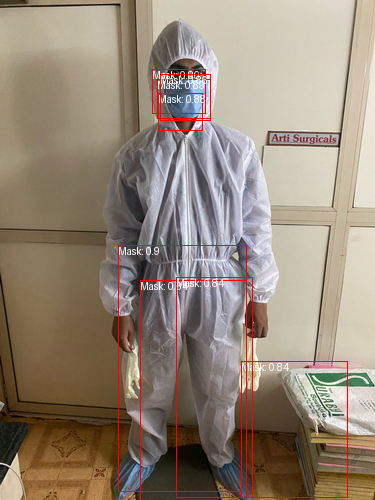

In [ ]:
from PIL import ImageDraw
from transformers import pipeline

model_path = "local/custom_owl_vit_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection")

image = cppe5["train"][16]["image"]

predictions = detector(
    image,
    candidate_labels=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
    threshold=0.10,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

image

## Raw model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[]


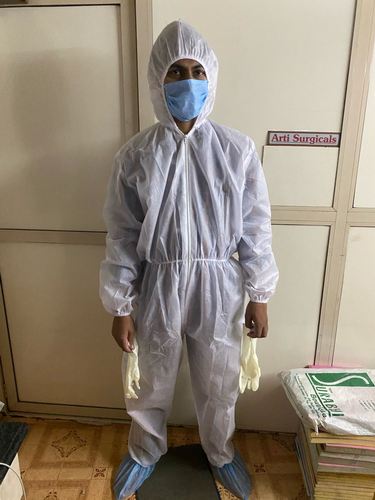

In [ ]:
model_path = "google/owlvit-base-patch32"
detector = pipeline(model=model_path, task="zero-shot-object-detection")  #model_path

image = cppe5["train"][16]["image"]

predictions = detector(
    image,
    candidate_labels=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
    threshold=0.10,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

image